## Constructing a galaxy velocity model based on galaxy overdensities

### Finding $f(\delta_g) = v$

The RMS velocity $v_{RMS}$ within each voxel binned in galaxy overdensity bins is shown below.

In [1]:
import my_functions as mf
from importlib import reload
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic

In [2]:
dmo = mf.LoadSimulation('/net/hydra/data2/quinten/data/dmo_fiducial/SOAP-HBT/halo_properties_0077.hdf5')
dmo.selext_galaxies_mass_threshold([10**11, np.inf])
dmo.load_all(128)

Mass range: 11.0 - inf
Galaxies: 7009562


/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:430: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/MRP/scripts/my_functions.py:102: RuntimeWarning: invalid value encountered in divide
  self.voxel_velocity = np.sqrt(voxel_velocity_sum_of_squares / voxel_count)
/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/MRP/scripts/my_functions.py:113: RuntimeWarning: invalid value 

In [3]:
vv = mf.VoxelVelocity(dmo.number_density, dmo.mean_galaxy_number_density, dmo.voxel_velocity[0], dmo.voxel_velocity_err[0])

/data2/quinten/MRP/scripts/my_functions.py:192: RuntimeWarning: Mean of empty slice
  bin_centers = [np.nanmean(values[bin_number == bin_numbers]) for bin_number in range(len(bin_edges)-1)]
/data2/quinten/MRP/scripts/my_functions.py:468: RuntimeWarning: invalid value encountered in divide
  v_binned = np.histogram(delta_g+1, bin_edges, weights=v)[0] / count
/data2/quinten/MRP/scripts/my_functions.py:423: RuntimeWarning: invalid value encountered in sqrt
  binned_err_inter = binned_std_inter / np.sqrt(count-1)
/data2/quinten/MRP/scripts/my_functions.py:423: RuntimeWarning: invalid value encountered in divide
  binned_err_inter = binned_std_inter / np.sqrt(count-1)
/data2/quinten/MRP/scripts/my_functions.py:429: RuntimeWarning: divide by zero encountered in divide
  binned_err_intra = np.sqrt(binned_err_intra_sum_of_squares) / (count-1)


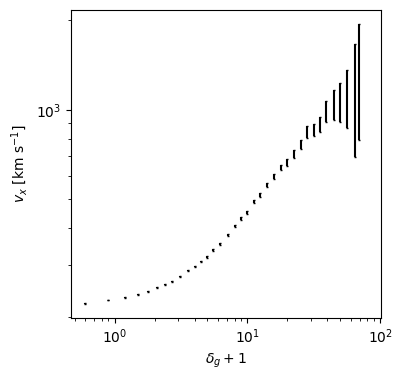

In [20]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

mf.plot_voxel_velocity(ax, vv, c='black')

ax.set(
    xscale='log',
    yscale='log',
    ylabel='$v_x$ [km s$^{-1}$]',
    xlabel=r'$\delta_g+1$',
)

plt.show()

This curve is described by two powerlaws stacked together in a nonlinear manner, $$v = \left(c^p + \left(\frac{x}{x_0}\right)^{s\cdot p}\right)^{\frac{1}{p}},$$where $c$ and $\left(\frac{x}{x_0}\right)^{s}$ are the powerlaws and $p$ regulates how they are combined. The best fit is shown below.

/data2/quinten/MRP/scripts/my_functions.py:208: RuntimeWarning: invalid value encountered in power
  return (c**p + (x/x0)**(s*p))**(1/p)


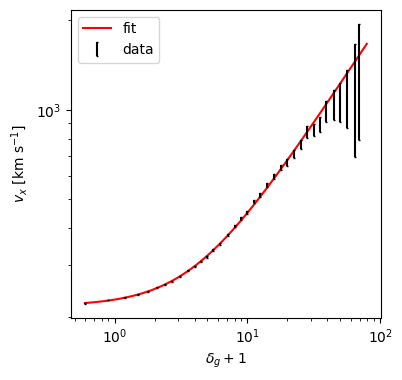

In [5]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

mf.plot_fit_voxel_velocity(ax, vv, c='r', label='fit', plot_data={'c': 'black', 'label': 'data'})

ax.set(
    xscale='log',
    yscale='log',
    ylabel='$v_x$ [km s$^{-1}$]',
    xlabel=r'$\delta_g+1$',
)

ax.legend()
plt.show()

### Finding $f(\delta_g, \frac{d\delta_g}{dx}) = v_x$

### 1. Visualizing $f(\delta_g) = |\frac{d\delta_g}{dx}|$ and $f(|\frac{d\delta_g}{dx}|) = v_x$

First, we calculate $\frac{d\delta_g}{dx}$ using the five point stencil.

In [6]:
# dddx: d\delta_g/dx - shape: n_bins x n_bins x n_bins
dddx = mf.five_point_stencil(dmo.galaxy_overdensity, dmo.boxsize, 0)

In [64]:
bins = mf.nonlinear_bins(dmo.number_density_per_galaxy)
dddx_binned, _, _ = binned_statistic(dmo.number_density.flatten(), np.abs(dddx.flatten()), bins=bins)
bin_centers = mf.calc_bin_centers(bins, dmo.number_density_per_galaxy) / dmo.mean_galaxy_number_density

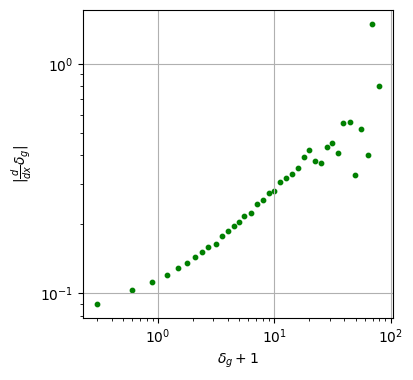

In [65]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

ax.scatter(bin_centers, dddx_binned, c='g', s=10)
ax.set(
    xscale='log',
    yscale='log',
    xlabel=r'$\delta_g+1$',
    ylabel=r'$|\frac{d}{dx}\delta_g|$'
)
ax.grid()

plt.show()

As expected, the galaxy overdensity and its absolute derivative are positively correlated

In [9]:
dddx_min = np.min(dddx[dddx>1e-10])
dddx_max = np.max(np.abs(dddx))
n_bins = int((dddx_max - dddx_min) * 10)

bin_edges = np.concatenate([[0], np.logspace(np.log10(dddx_min), np.log10(dddx_max), n_bins)])

In [10]:
dddx[np.abs(dddx) < 1e-10] = 1e-11
dvv = mf.VoxelVelocity(np.abs(dddx), 1, dmo.voxel_velocity[0], dmo.voxel_velocity_err[0])

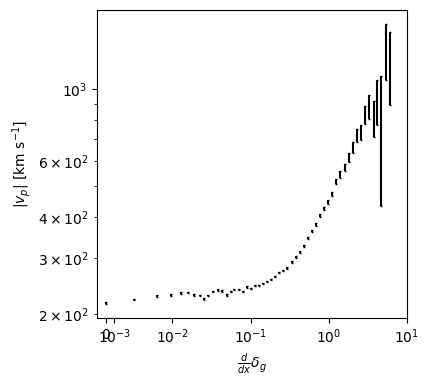

In [11]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

mf.plot_voxel_velocity(ax, dvv, c='black', bin_edges=bin_edges)

ax.set(
    yscale='log',
    ylabel='$|v_p|$ [km s$^{-1}$]',
    xlabel=r'$\frac{d}{dx}\delta_g$',
    xlim=[-1e-3,10],
)
ax.set_xscale('symlog', linthresh=3e-3, linscale=.3)

plt.show()


The relation $f(|\frac{d\delta_g}{dx})|=v_x$ behaves quite similar as the relation $f(\delta_g)=v_x$. Using the same formula, the following fit through the data can be obtained:

/data2/quinten/MRP/scripts/my_functions.py:192: RuntimeWarning: Mean of empty slice
  bin_centers = [np.nanmean(values[bin_number == bin_numbers]) for bin_number in range(len(bin_edges)-1)]
/data2/quinten/MRP/scripts/my_functions.py:468: RuntimeWarning: invalid value encountered in divide
  v_binned = np.histogram(delta_g+1, bin_edges, weights=v)[0] / count
/data2/quinten/MRP/scripts/my_functions.py:423: RuntimeWarning: invalid value encountered in sqrt
  binned_err_inter = binned_std_inter / np.sqrt(count-1)
/data2/quinten/MRP/scripts/my_functions.py:208: RuntimeWarning: invalid value encountered in power
  return (c**p + (x/x0)**(s*p))**(1/p)


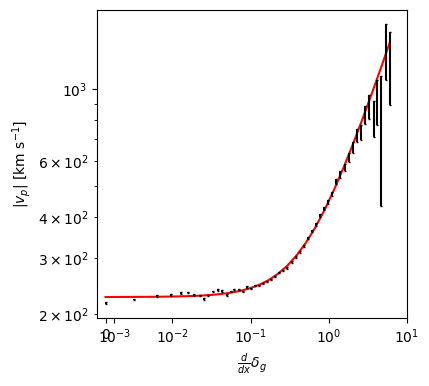

In [14]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

mf.plot_fit_voxel_velocity(ax, dvv, c='r', label='Fit', bin_edges=bin_edges, plot_data={'c': 'black', 'label': 'Data'})

ax.set(
    yscale='log',
    ylabel='$|v_p|$ [km s$^{-1}$]',
    xlabel=r'$\frac{d}{dx}\delta_g$',
    xlim=[-1e-3,10],
)
ax.set_xscale('symlog', linthresh=3e-3, linscale=.3)

plt.show()


### 2. Slicing the data in bins

We slice the data in $\frac{d\delta_g}{dx}$ bins and observe the relation between $\delta_g$ and $v$ for individual slices

In [37]:
def slice_dddx(dddx: np.ndarray, n_bins: int):
    """This function slices the data in d\\delta_g/dx bins and outputs masks corresponding to each bin.

    Args:
        dddx (np.ndarray): array of shape n_bins x n_bins x n_bins containing the derivatives of the galaxy overdensity
        n_bins (int): number of d\\delta_g/dx bins

    Returns:
        out (tuple[np.ndarray,list[np.ndarray]]):
        - **bin_centers** (np.ndarray): average value of data inside each bin
        - **dddx_masks** (list[np.ndarray]): masks corresponding to the bins
    """
    bin_edges = np.concatenate([[0], np.logspace(np.log10(min(list(filter(lambda x: x>1e-10, dddx.flatten())))), np.log10(dddx.max()*1.001), n_bins)])
    bin_centers = mf.calc_bin_centers(bin_edges, dddx)

    dddx_masks = []
    for lower, upper in zip(bin_edges[:-1], bin_edges[1:]):
        dddx_masks.append((dddx >= lower) & (dddx < upper))

    return bin_centers, dddx_masks

In [34]:
reload(mf)

<module 'my_functions' from '/data2/quinten/MRP/scripts/my_functions.py'>

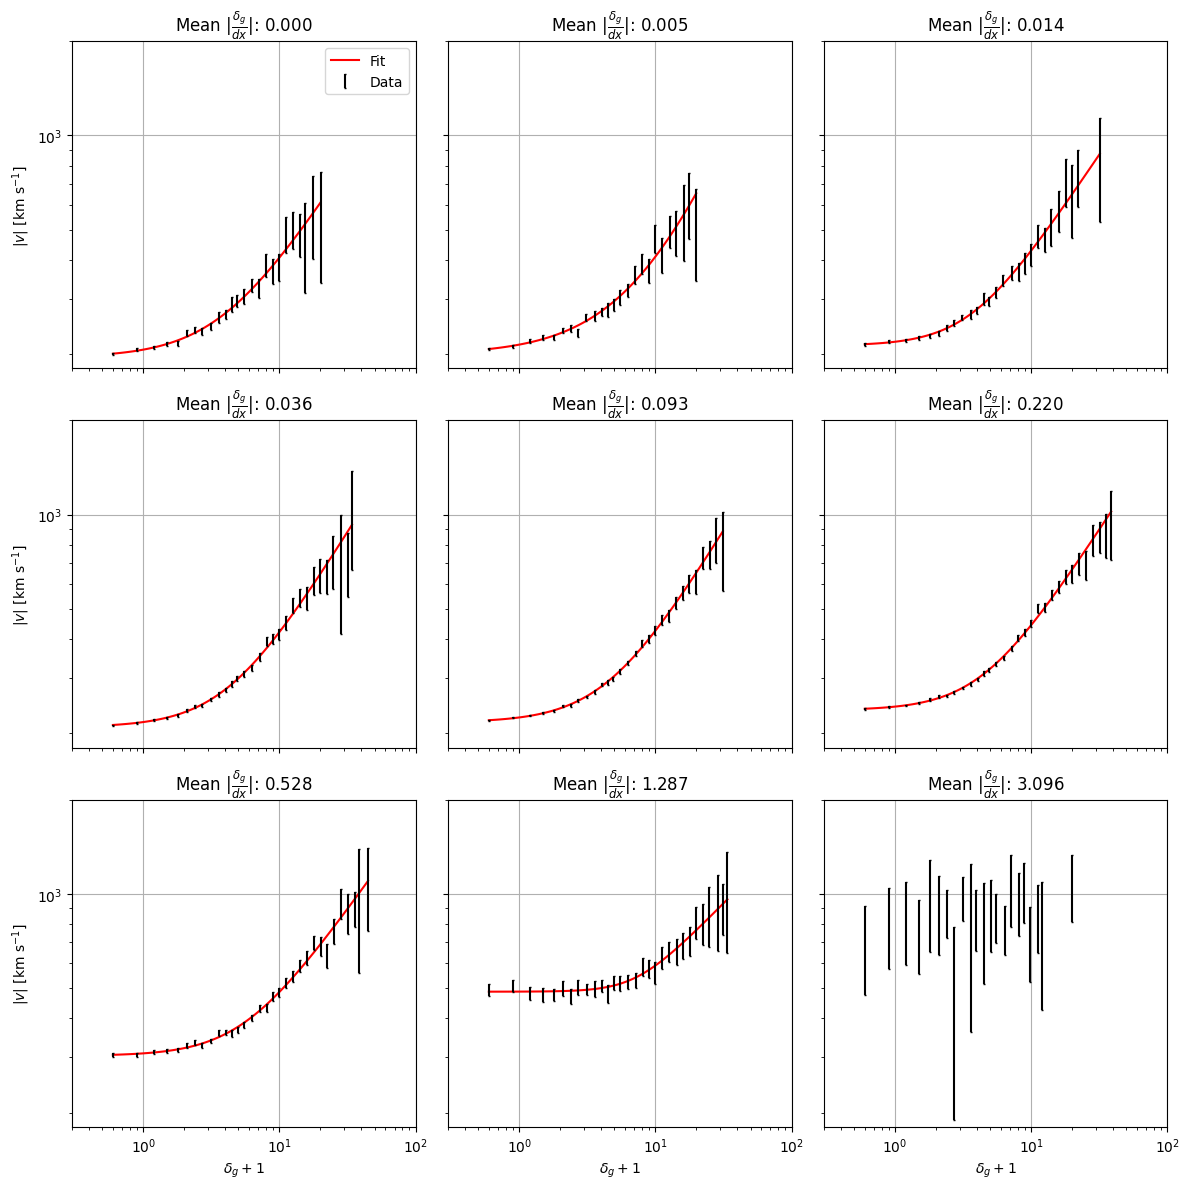

In [36]:
bin_centers, masks = slice_dddx(dddx, 9)

fig, ax = plt.subplots(3, 3, figsize=[12,12], sharex=True, sharey=True)

for axis, mask, bin_center in zip(ax.flatten(), masks, bin_centers):
    vv = mf.VoxelVelocity(dmo.number_density[mask], dmo.mean_galaxy_number_density, dmo.voxel_velocity[0][mask], dmo.voxel_velocity_err[0][mask])
    try:
        mf.plot_fit_voxel_velocity(axis, vv, c='r', label='Fit', plot_data={'c': 'black', 'label': 'Data'})
    except RuntimeError:
        mf.plot_voxel_velocity(axis, vv, c='black', label='Data')
    axis.set(
        xscale='log',
        yscale='log',
        xlim=[.3, 100],
        ylim=[180, 2e3],
        title=f'Mean $|\\frac{{\\delta_g}}{{dx}}|$: {bin_center:.3f}'
    )
    axis.grid()
ax[0,0].legend()

for axis in ax[2, :]:
    axis.set_xlabel(r'$\delta_g+1$')
for axis in ax[:, 0]:
    axis.set_ylabel(r'$|v|$ [km s$^{-1}$]')
fig.tight_layout()
plt.show()

We create a function that can create a lot of fits at once to observe the behavior of the fitting parameters at different $\frac{d\delta_g}{dx}$.

In [59]:
def dddx_fits(vv, masks):
    fits, errors = [], []
    no_fit = []
    last_fit = None
    for i, mask in enumerate(masks):
        vv_masked = mf.VoxelVelocity(vv.number_density[mask], vv.n_g_mean, vv.voxel_velocity[mask], vv.voxel_velocity_err[mask])
        if np.sum(mask) > 0:
            try:
                _, fit, error = mf.fit_voxel_velocity(vv_masked, p0=last_fit)
                if np.sum(error) == np.inf:      # If any error is infinity: remove this datapoint
                    fit, error = [[np.nan]*4]*2
                    no_fit.append(i)
                else:
                    last_fit = fit
            except (RuntimeError, TypeError, ValueError):
                fit, error = [[np.nan]*4]*2
                no_fit.append(i)
        else:
            fit, error = [[np.nan]*4]*2
            no_fit.append(i)
        fits.append(fit)
        errors.append(error)
    print(f'No fit found in {len(no_fit)} bins')
    return np.array(fits), np.array(errors)

No fit found in 43 bins


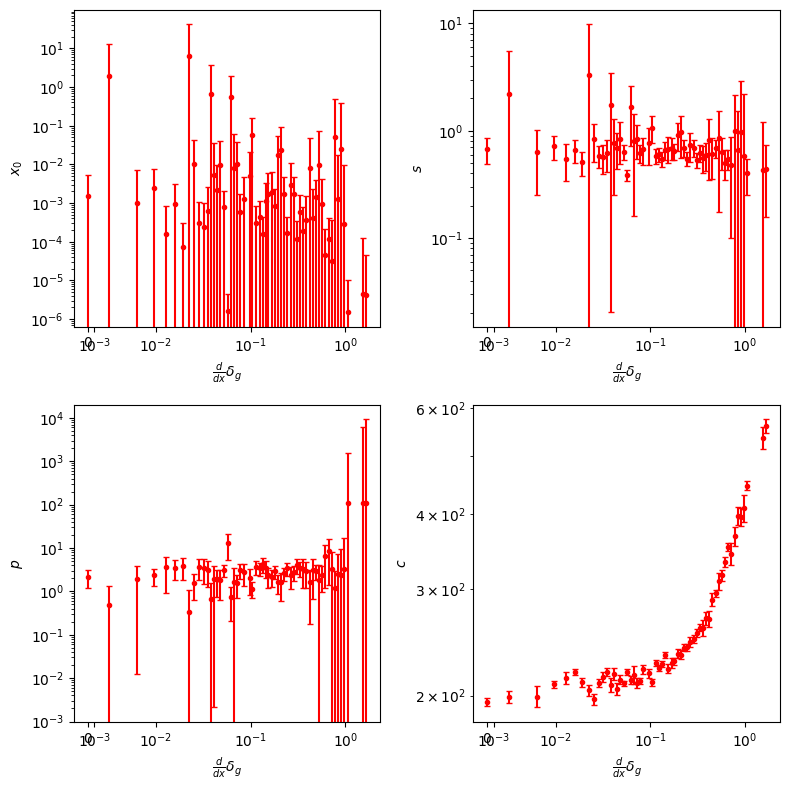

In [62]:
vv = mf.VoxelVelocity(dmo.number_density, dmo.mean_galaxy_number_density, dmo.voxel_velocity[0], dmo.voxel_velocity_err[0])

bin_centers, masks = slice_dddx(dddx, 100)
#fits, errors = dddx_fits(masks, dmo.number_density_per_galaxy, dmo.mean_galaxy_number_density, dmo.vp[:, 0])
fits, errors = dddx_fits(vv, masks)

fig, ax = plt.subplots(2, 2, figsize=[8,8])

for axis, fit, error in zip(ax.flatten(), fits.T, errors.T):
    axis.errorbar(bin_centers, fit, error, linestyle='', capsize=2, color='r', marker='.')
    axis.set(
        xlabel=r'$\frac{d}{dx}\delta_g$',
    )
    axis.set_xscale('symlog', linthresh=10**-2.5, linscale=.2)

ax[0,0].set(
    ylabel='$x_0$',
    yscale='log',
)
ax[0,1].set(
    ylabel='$s$',
    yscale='log',
)
ax[1,0].set(
    ylabel='$p$',
    yscale='log',
)
ax[1,1].set(
    ylabel='$c$',
    yscale='log',
)
fig.tight_layout()
plt.show()

### 3. Finding a fitting model for $f(\delta_g, \frac{d\delta_g}{dx})$

Since we already have an expression for $f(\delta_g)=v_x$, we can include $\frac{d\delta_g}{dx}$ in the model by making the parameters of $f(\delta_g)$ functions of $\frac{d\delta_g}{dx}$, leading to the model$$v = \left(c^p + \left(\frac{x}{x_0}\right)^{s\cdot p}\right)^{\frac{1}{p}},$$with$$s=s(\frac{d}{dx}\delta_g),~x_0=x_0(\frac{d}{dx}\delta_g),~p=p(\frac{d}{dx}\delta_g)~\text{and}~c=c(\frac{d}{dx}\delta_g).$$I will start simple by only allowing $c$ to be varied, following the same curve as $f(\delta_g)=v_x$, resulting in$$s=s_0,~x_0=x_{0,0},~p=p_0,~\text{and}~c=f(\frac{d}{dx}\delta_g).$$


### Next steps

Another important step is setting up some sort of likelihood function to test the performance of different models